# **Case Datarisk - Score de Crédito**

## **Importa as bibliotecas e Carrega os Dados**

In [280]:
from utils.load_df import load_df
from utils.convert_to_datetime import convert_to_datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

import requests
from pathlib import Path

from sklearn.metrics import roc_curve

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 

In [281]:
# Carregar os DataFrames
df_train = load_df("./data/train.parquet")
X_train = df_train.drop('inadimplente', axis=1)
y_train = df_train['inadimplente']

df_test = load_df("./data/test.parquet")
X_test = df_test.drop('inadimplente', axis=1)
y_test = df_test['inadimplente']

df_val= load_df("./data/validation.parquet")
X_val = df_val.drop('inadimplente', axis=1)
y_val = df_val['inadimplente']

## **Modelagem**

### **Funções**


In [282]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc

def train_and_evaluate_model(model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test):

  # Treinar o modelo
  model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc')

  # Fazer previsões no conjunto de teste
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  y_pred = model.predict(X_test)

  return y_pred_proba, y_pred


In [283]:
def plotProbHistograms(y_pred_proba, y_test, ax):
  """
  Gera e exibe histogramas das probabilidades previstas para múltiplos modelos
  em um eixo matplotlib específico.

  Args:
      y_pred_proba (np.array): Probabilidades previstas para a classe positiva (1).
      y_test (pd.Series): Valores verdadeiros da target.
      ax (matplotlib.axes.Axes): O eixo onde os histogramas serão desenhados.
  """

  df_plot = pd.DataFrame({
      'Probabilidade': y_pred_proba,
      'Classe': y_test.astype(int)
  })

  # Para cada classe, faz um subplot no eixo fornecido
  sns.histplot(
      data=df_plot[df_plot['Classe'] == 0],
      x='Probabilidade',
      bins=30,
      stat='density',
      color='blue',
      label='Classe 0 (Não Inadimplente)',
      kde=True, # Adicionar Kernel Density Estimate para suavizar o histograma
      ax=ax # Especifica o eixo para plotar
  )
  sns.histplot(
      data=df_plot[df_plot['Classe'] == 1],
      x='Probabilidade',
      bins=30,
      stat='density',
      color='red',
      label='Classe 1 (Inadimplente)',
      kde=True, # Adicionar Kernel Density Estimate para suavizar o histograma
      ax=ax # Especifica o eixo para plotar
  )

  ax.set_title('Distribuição das Probabilidades Previstas por Classe', fontsize=14)
  ax.set_xlabel('Probabilidade Prevista')
  ax.set_ylabel('Densidade')
  ax.legend()
  ax.grid(True)

In [284]:
def evaluate_metrics(y_test, y_pred_proba):
    """
    Calcula as principais métricas de avaliação para um modelo de classificação binária.
    Retorna um DataFrame com os valores.
    """

    # AUC ROC
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Curva PR e PR-AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc_score = auc(recall_curve, precision_curve)

    # Estatística KS (corrigida)
    df_ks = pd.DataFrame({'proba': y_pred_proba, 'target': y_test})
    df_ks = df_ks.sort_values('proba', ascending=False).reset_index(drop=True)

    df_ks['cum_pos'] = (df_ks['target'] == 1).cumsum() / (df_ks['target'] == 1).sum()
    df_ks['cum_neg'] = (df_ks['target'] == 0).cumsum() / (df_ks['target'] == 0).sum()
    df_ks['ks'] = df_ks['cum_pos'] - df_ks['cum_neg']

    ks_score = df_ks['ks'].max()
    ks_index = df_ks['ks'].idxmax()
    ks_threshold = df_ks['proba'].iloc[ks_index]

    # Precision e Recall no threshold KS
    precision = precision_score(y_test, y_pred_proba >= ks_threshold)
    recall = recall_score(y_test, y_pred_proba >= ks_threshold)

    metrics = pd.DataFrame({
        'Métrica': [
            'AUC (ROC)',
            'PR-AUC',
            'KS Statistic',
            'KS Threshold',
            'Precision (no KS)',
            'Recall (no KS)'
        ],
        'Valor': [
            round(auc_score, 4),
            round(pr_auc_score, 4),
            round(ks_score, 4),
            round(ks_threshold, 4),
            round(precision, 4),
            round(recall, 4)
        ]
    })

    return metrics


def plot_ks_curve(y_test, y_proba, ax: plt.Axes):
    """
    Plota a curva KS (Kolmogorov-Smirnov) em um eixo matplotlib.
    """

    # Preparar dados
    df = pd.DataFrame({'y': y_test, 'proba': y_proba})
    df = df.sort_values('proba', ascending=False).reset_index(drop=True)

    df['cum_pos'] = (df['y'] == 1).cumsum() / (df['y'] == 1).sum()
    df['cum_neg'] = (df['y'] == 0).cumsum() / (df['y'] == 0).sum()
    df['ks'] = df['cum_pos'] - df['cum_neg']

    ks_stat = df['ks'].max()
    ks_idx = df['ks'].idxmax()

    # Plot curvas acumuladas
    ax.plot(df.index / len(df), df['cum_pos'], label="Positivos acumulados", color="blue")
    ax.plot(df.index / len(df), df['cum_neg'], label="Negativos acumulados", color="orange")
    ax.plot(df.index / len(df), df['ks'], label="KS Curve", linestyle="--", color="green")

    # Marcar o ponto máximo do KS
    ax.vlines(ks_idx / len(df),
              ymin=df['cum_neg'].iloc[ks_idx],
              ymax=df['cum_pos'].iloc[ks_idx],
              colors="red", linestyles="dashed")
    ax.text(ks_idx / len(df),
            df['ks'].iloc[ks_idx],
            f"KS = {ks_stat:.2%}", color="red", fontsize=10)

    ax.set_title("Curva KS")
    ax.set_xlabel("Proporção da amostra")
    ax.set_ylabel("Taxa acumulada")
    ax.legend()
    ax.grid(True)

    return ks_stat


def plot_report(y_test, y_pred_proba, title='Relatório de Performance'):
    """
    Gera um dashboard 2x2 com as principais métricas de avaliação para um modelo de classificação binária.
    Inclui AUC, PR-AUC, KS e distribuição de probabilidades.
    """

    # 1. CÁLCULO DAS MÉTRICAS
    metrics = evaluate_metrics(y_test, y_pred_proba)
    display(metrics)

    auc_score = metrics.loc[metrics['Métrica'] == 'AUC (ROC)', 'Valor'].values[0]
    pr_auc_score = metrics.loc[metrics['Métrica'] == 'PR-AUC', 'Valor'].values[0]

    # Curva Precision-Recall
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # 2. DASHBOARD 2x2
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    fig.suptitle(title, fontsize=20)

    # --- Gráfico 1: Curva Precision-Recall ---
    ax1 = axes[0, 0]
    ax1.plot(recall_curve, precision_curve, label=f'PR-AUC = {pr_auc_score:.4f}', color='royalblue')
    ax1.plot([0, 1], [metrics.loc[metrics['Métrica'] == 'Precision (no KS)', 'Valor'].values[0]]*2,
             linestyle="--", color="gray", alpha=0.6, label="Precision @ KS")
    ax1.set_title('Curva Precision-Recall', fontsize=14)
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.legend()
    ax1.grid(True)

    # --- Gráfico 2: Curva ROC ---
    ax2 = axes[0, 1]
    ax2.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='darkorange')
    ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax2.set_title('Curva ROC', fontsize=14)
    ax2.set_xlabel('FPR (Taxa de Falsos Positivos)')
    ax2.set_ylabel('TPR (Taxa de Verdadeiros Positivos)')
    ax2.legend()
    ax2.grid(True)

    # --- Gráfico 3: Curva KS ---
    from matplotlib.ticker import PercentFormatter
    ax3 = axes[1, 0]
    ks_value = plot_ks_curve(y_test, y_pred_proba, ax3)
    ax3.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax3.set_title(f'Curva KS (KS={ks_value:.2%})', fontsize=14)

    # --- Gráfico 4: Distribuição das Probabilidades ---
    ax4 = axes[1, 1]
    plotProbHistograms(y_pred_proba, y_test, ax4)
    ax4.set_title('Distribuição das Probabilidades', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [285]:
def plot_feature_importance(feature_importances):

  # Plotar a importância das features
  plt.figure(figsize=(8, 6))
  sns.barplot(x='Importance', y='Feature', data=feature_importances)
  plt.title('Importância das Features')
  plt.xlabel('Importância')
  plt.ylabel('Feature')
  plt.tight_layout()
  plt.show()

In [286]:
params = {
    'class_weight': 'balanced',
    'seed': 42
}

# Criar o modelo LightGBM
model = lgb.LGBMClassifier(**params)
y_pred_proba, y_pred = train_and_evaluate_model(model)

[LightGBM] [Info] Number of positive: 1313, number of negative: 48417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9520
[LightGBM] [Info] Number of data points in the train set: 49730, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


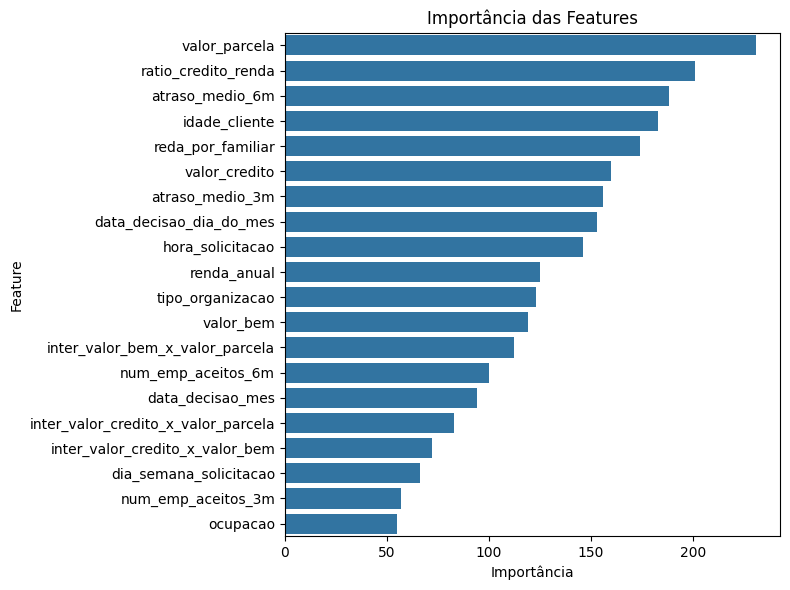

In [287]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plot_feature_importance(feature_importances)

,Métrica,Valor
0,AUC (ROC),0.6032
1,PR-AUC,0.0064
2,KS Statistic,0.2111
3,KS Threshold,0.1654
4,Precision (no KS),0.0071
5,Recall (no KS),0.5000


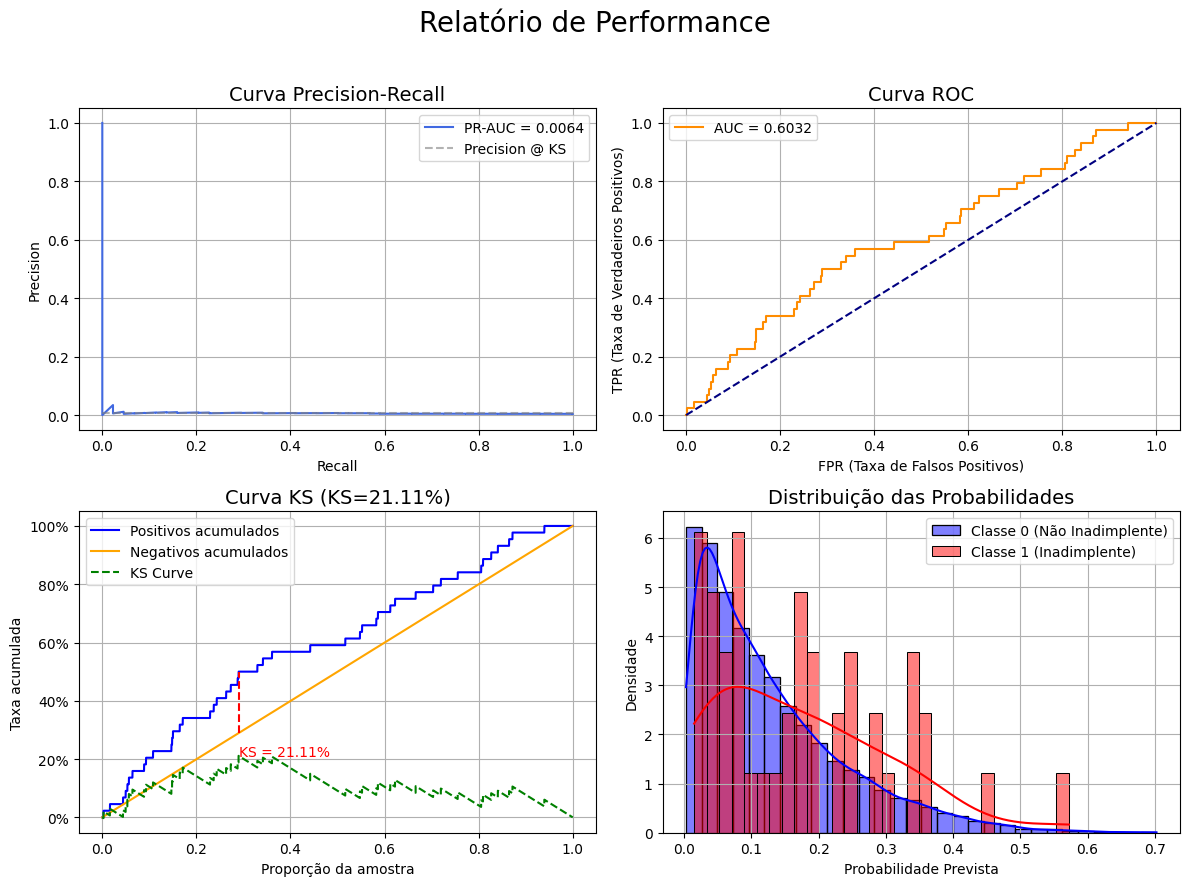

In [288]:
plot_report(y_test, y_pred_proba)

## Threashold Manual de Feature Importance

In [296]:
features_to_keep = feature_importances[feature_importances['Importance'] >= 150]['Feature'].tolist()

X_train_biggest_fi = X_train[features_to_keep]
X_test_biggest_fi = X_test[features_to_keep]
X_val_biggest_fi = X_val[features_to_keep]

print(f"Número de features após descarte: {len(features_to_keep)}")
print("Features restantes:")
print(features_to_keep)

Número de features após descarte: 8
Features restantes:
['valor_parcela', 'ratio_credito_renda', 'atraso_medio_6m', 'idade_cliente', 'reda_por_familiar', 'valor_credito', 'atraso_medio_3m', 'data_decisao_dia_do_mes']


In [297]:
params = {
    'class_weight': 'balanced',
    'seed': 42
}

# Criar o modelo LightGBM
model = lgb.LGBMClassifier(**params)
y_pred_proba, y_pred = train_and_evaluate_model(model, X_train=X_train_biggest_fi, y_train=y_train, X_test=X_test_biggest_fi, X_val=X_val_biggest_fi)

[LightGBM] [Info] Number of positive: 1313, number of negative: 48417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 49730, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [289]:
na_cols = X_train.isna().sum()
na_cols = na_cols[na_cols > 0]
if not na_cols.empty:
    display(na_cols)
else:
    print('Não há valores NA em X_train')

y_na = y_train.isna().sum()
if y_na > 0:
    display(y_na)
else:
    print('Não há valores NA em y_train')

Não há valores NA em X_train
Não há valores NA em y_train


,Métrica,Valor
0,AUC (ROC),0.6130
1,PR-AUC,0.0055
2,KS Statistic,0.1992
3,KS Threshold,0.2188
4,Precision (no KS),0.0059
5,Recall (no KS),0.6591


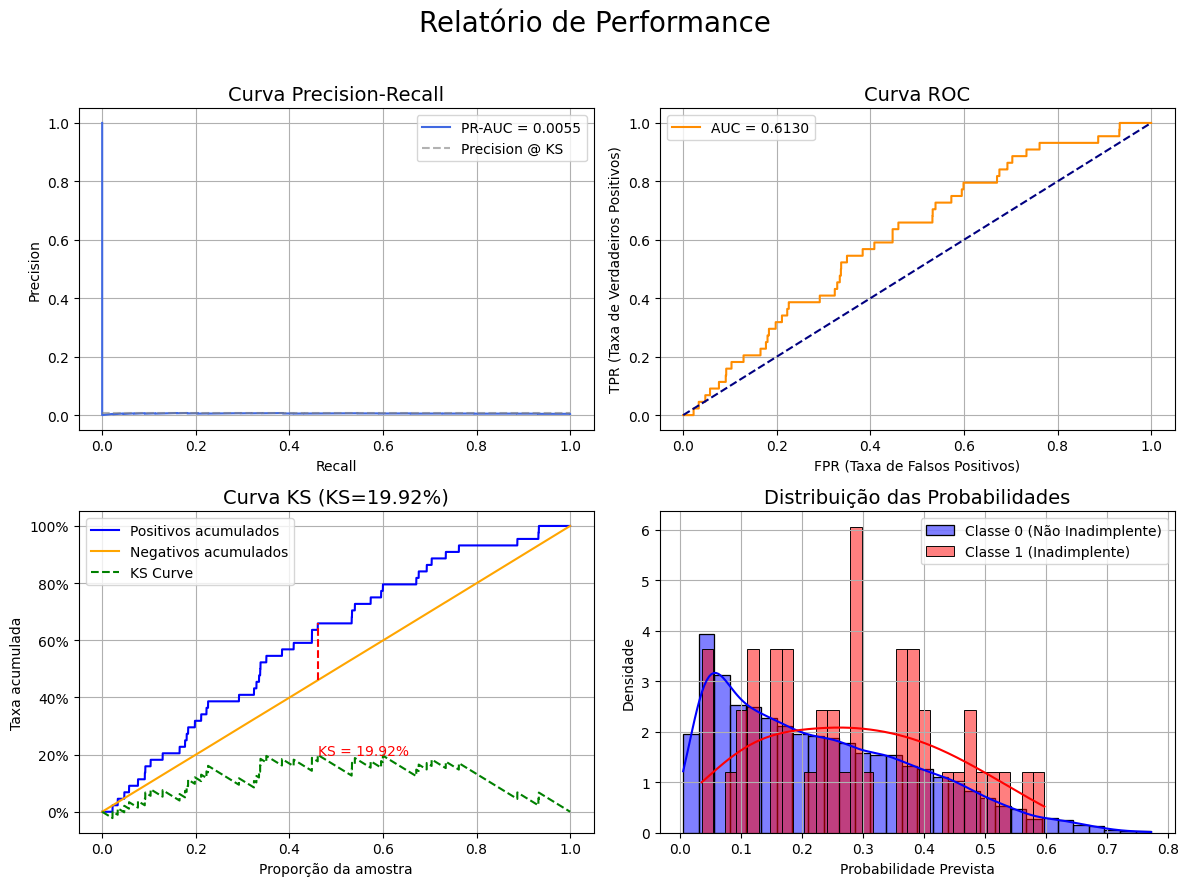

In [298]:
plot_report(y_test, y_pred_proba)

## Seleção de Features com Boruta

In [291]:
def select_features_boruta(X_train, y_train):
    # Random Forest Classifier
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

    # Boruta
    feat_selector = BorutaPy(
        estimator=rf,
        n_estimators='auto',
        verbose=2,
        max_iter=20,
        random_state=42
    )

    feat_selector.fit(X_train.values, y_train.squeeze().values)

    # Selecionar as features aprovadas pelo Boruta
    cols_selected_boruta = X_train.columns[feat_selector.support_].to_list()
    print(f'Número de features selecionadas pelo Boruta: {len(cols_selected_boruta)}')

    return cols_selected_boruta

cols_selected_boruta = select_features_boruta(X_train, y_train)

Iteration: 	1 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	2 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	3 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	4 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	5 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	6 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	7 / 20
Confirmed: 	0
Tentative: 	61
Rejected: 	0
Iteration: 	8 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	9 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	10 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	11 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	12 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	13 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	14 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	15 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	16 / 20
Confirmed: 	5
Tentative: 	3
Rejected: 	53
Iteration: 	17 / 

In [292]:
print("Features selecionadas pelo Boruta:", cols_selected_boruta)

Features selecionadas pelo Boruta: ['valor_credito', 'valor_bem', 'valor_parcela', 'ratio_credito_renda', 'inter_valor_credito_x_valor_bem']


In [293]:
X_train_boruta = X_train[cols_selected_boruta]
X_test_boruta = X_test[cols_selected_boruta]
X_val_boruta = X_val[cols_selected_boruta]

In [294]:
params = {
    'class_weight': 'balanced',
    'seed': 42
}

# Criar o modelo LightGBM
model = lgb.LGBMClassifier(**params)
y_pred_proba, y_pred = train_and_evaluate_model(model, X_train=X_train_boruta, X_test=X_test_boruta, X_val=X_val_boruta)

[LightGBM] [Info] Number of positive: 1313, number of negative: 48417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 49730, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


,Métrica,Valor
0,AUC (ROC),0.5978
1,PR-AUC,0.0058
2,KS Statistic,0.1980
3,KS Threshold,0.4050
4,Precision (no KS),0.0070
5,Recall (no KS),0.4773


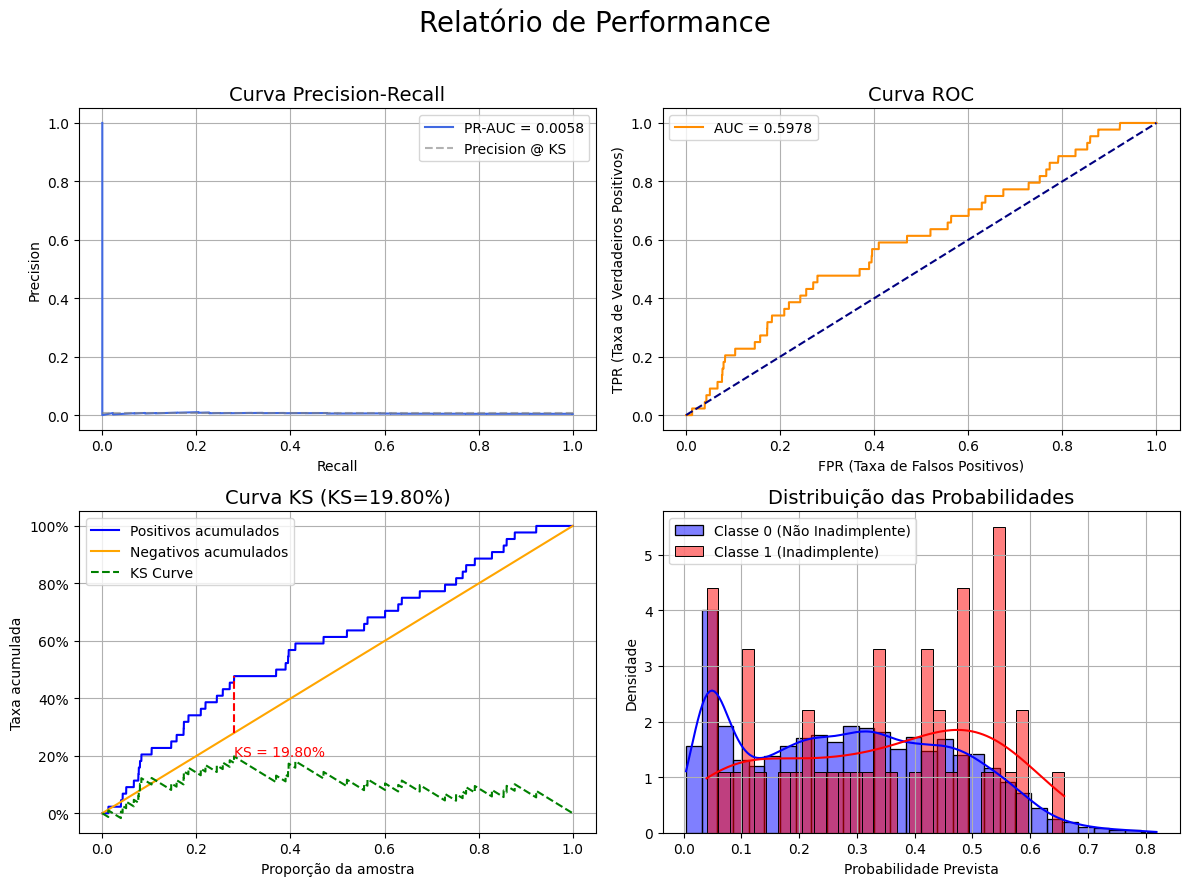

In [295]:
plot_report(y_test, y_pred_proba)

## **SMOTE**

In [299]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [301]:
counter = Counter(y_train)
print(counter)

Counter({0.0: 48417, 1.0: 1313})


In [302]:
oversample = SMOTE(sampling_strategy=0.1)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [303]:
counter = Counter(y_train_smote)
print(counter)

Counter({0.0: 48417, 1.0: 4841})


In [304]:
model = lgb.LGBMClassifier()
y_pred_proba, y_pred = train_and_evaluate_model(model, X_train=X_train_smote, y_train=y_train_smote)

[LightGBM] [Info] Number of positive: 4841, number of negative: 48417
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9990
[LightGBM] [Info] Number of data points in the train set: 53258, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090897 -> initscore=-2.302730
[LightGBM] [Info] Start training from score -2.302730


,Métrica,Valor
0,AUC (ROC),0.6070
1,PR-AUC,0.0057
2,KS Statistic,0.2379
3,KS Threshold,0.0079
4,Precision (no KS),0.0060
5,Recall (no KS),0.7500


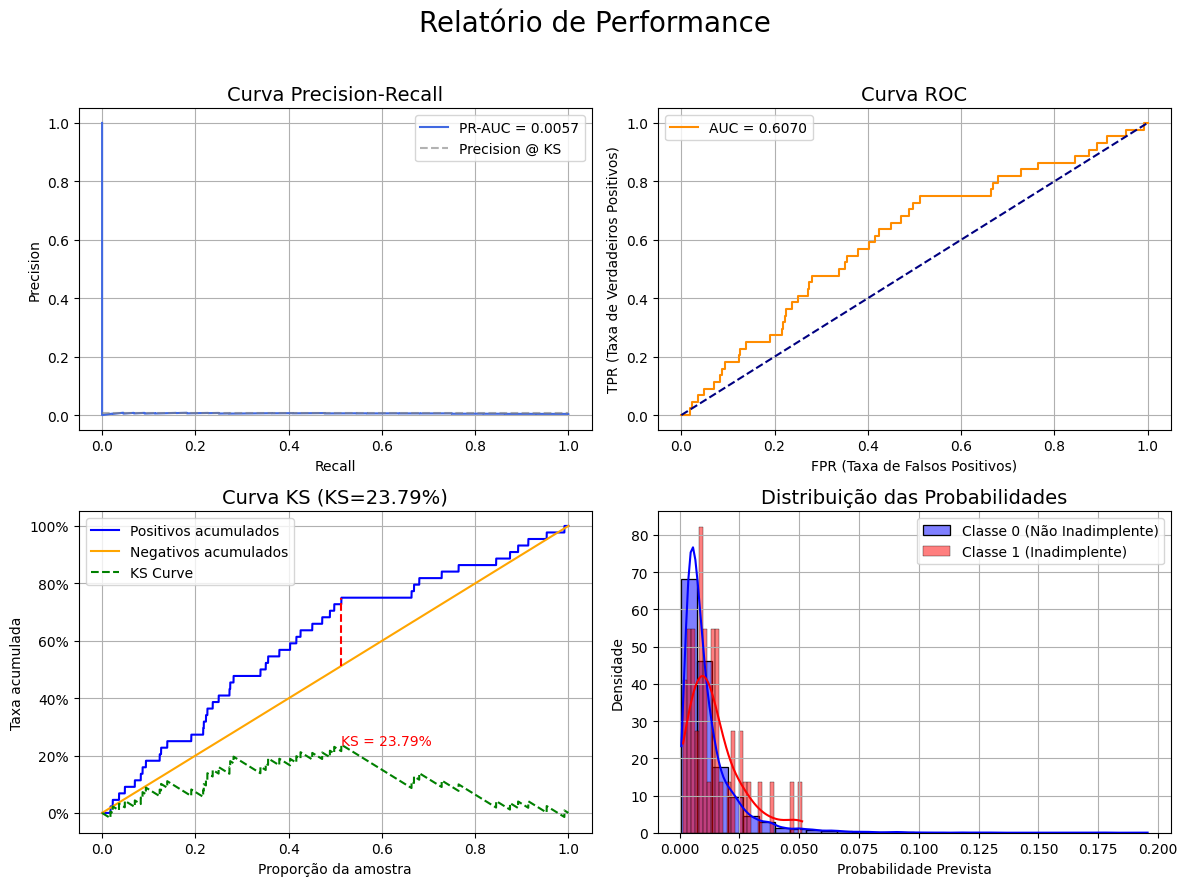

In [305]:
plot_report(y_test, y_pred_proba)

## Otimiza Hiperparâmetros com Optuna

In [316]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score


def objective(trial, X_train, y_train, X_val, y_val):
    """
    Função que o Optuna irá otimizar.
    Ela testa uma combinação de hiperparâmetros e retorna o score (AUC).
    """
    # Define o espaço de busca dos hiperparâmetros
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True), # L1 Regularization
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True), # L2 Regularization
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0), # Similar a colsample_bytree
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0), # Similar a subsample
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7)
    }

    # Instancia o modelo com os parâmetros da tentativa atual
    model = lgb.LGBMClassifier(**params)

    # n_splits = 5
    # tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # # O score será a média dos AUCs de cada fold
    # score = cross_val_score(model, X, y, cv=tscv, scoring='roc_auc', n_jobs=-1)
    
    # # Retorna a média dos scores. O Optuna tentará maximizar este valor.
    # return score.mean()

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    return auc

In [ ]:
study = optuna.create_study(direction='maximize')

# Inicia a otimização. O Optuna irá chamar a função 'objective' 50 vezes.
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=30, show_progress_bar=True)

[I 2025-10-20 18:26:09,783] A new study created in memory with name: no-name-1fdfa551-ed37-48aa-9f33-1bed14f34e57
Best trial: 0. Best value: 0.602821:   3%|▎         | 1/30 [00:11<05:25, 11.23s/it]

[I 2025-10-20 18:26:21,017] Trial 0 finished with value: 0.6028214094446019 and parameters: {'n_estimators': 476, 'learning_rate': 0.005850890230609463, 'num_leaves': 375, 'max_depth': 8, 'lambda_l1': 0.004952947871454364, 'lambda_l2': 5.733181607017976, 'feature_fraction': 0.9261007891672752, 'bagging_fraction': 0.7813847833702876, 'bagging_freq': 2}. Best is trial 0 with value: 0.6028214094446019.


Best trial: 1. Best value: 0.608064:   7%|▋         | 2/30 [00:21<04:57, 10.62s/it]

[I 2025-10-20 18:26:31,215] Trial 1 finished with value: 0.6080635100652112 and parameters: {'n_estimators': 715, 'learning_rate': 0.020875142595945965, 'num_leaves': 196, 'max_depth': 7, 'lambda_l1': 3.258997417207435e-08, 'lambda_l2': 1.1130345901450546e-08, 'feature_fraction': 0.6213239970904203, 'bagging_fraction': 0.8705816186871344, 'bagging_freq': 4}. Best is trial 1 with value: 0.6080635100652112.


Best trial: 1. Best value: 0.608064:  10%|█         | 3/30 [00:32<04:54, 10.91s/it]

[I 2025-10-20 18:26:42,456] Trial 2 finished with value: 0.5819651576725576 and parameters: {'n_estimators': 289, 'learning_rate': 0.007776609922534242, 'num_leaves': 306, 'max_depth': 10, 'lambda_l1': 0.6257101556768567, 'lambda_l2': 0.00013412904562020705, 'feature_fraction': 0.883574079372619, 'bagging_fraction': 0.9720104729455298, 'bagging_freq': 1}. Best is trial 1 with value: 0.6080635100652112.


Best trial: 1. Best value: 0.608064:  13%|█▎        | 4/30 [00:36<03:29,  8.06s/it]

[I 2025-10-20 18:26:46,156] Trial 3 finished with value: 0.590619664177929 and parameters: {'n_estimators': 282, 'learning_rate': 0.04519754136438696, 'num_leaves': 64, 'max_depth': 8, 'lambda_l1': 0.01674983918233723, 'lambda_l2': 0.002340026580004976, 'feature_fraction': 0.6440804033466505, 'bagging_fraction': 0.6987240309045634, 'bagging_freq': 7}. Best is trial 1 with value: 0.6080635100652112.


Best trial: 1. Best value: 0.608064:  17%|█▋        | 5/30 [01:03<06:16, 15.05s/it]

[I 2025-10-20 18:27:13,609] Trial 4 finished with value: 0.598457612702013 and parameters: {'n_estimators': 1086, 'learning_rate': 0.024042583527638432, 'num_leaves': 156, 'max_depth': 9, 'lambda_l1': 4.6746870709798044e-07, 'lambda_l2': 5.382947757375149e-06, 'feature_fraction': 0.7680090822074854, 'bagging_fraction': 0.85049622858408, 'bagging_freq': 3}. Best is trial 1 with value: 0.6080635100652112.


Best trial: 1. Best value: 0.608064:  20%|██        | 6/30 [01:11<05:01, 12.54s/it]

[I 2025-10-20 18:27:21,283] Trial 5 finished with value: 0.6068966386289889 and parameters: {'n_estimators': 905, 'learning_rate': 0.024056634475231934, 'num_leaves': 31, 'max_depth': 11, 'lambda_l1': 7.149226247938133, 'lambda_l2': 0.00022661834901766245, 'feature_fraction': 0.7269464990564455, 'bagging_fraction': 0.8617219686620348, 'bagging_freq': 6}. Best is trial 1 with value: 0.6080635100652112.


Best trial: 6. Best value: 0.619553:  23%|██▎       | 7/30 [01:27<05:13, 13.62s/it]

[I 2025-10-20 18:27:37,112] Trial 6 finished with value: 0.6195532873389409 and parameters: {'n_estimators': 829, 'learning_rate': 0.016804818985399834, 'num_leaves': 336, 'max_depth': 8, 'lambda_l1': 2.9303933498368112e-06, 'lambda_l2': 1.3432194434037782e-05, 'feature_fraction': 0.8588251554805411, 'bagging_fraction': 0.6485056955195648, 'bagging_freq': 4}. Best is trial 6 with value: 0.6195532873389409.


Best trial: 6. Best value: 0.619553:  27%|██▋       | 8/30 [01:37<04:37, 12.60s/it]

[I 2025-10-20 18:27:47,547] Trial 7 finished with value: 0.6023954887691775 and parameters: {'n_estimators': 510, 'learning_rate': 0.06107338037841763, 'num_leaves': 473, 'max_depth': 8, 'lambda_l1': 3.768355647357367e-05, 'lambda_l2': 9.004763668724891, 'feature_fraction': 0.9329986748451544, 'bagging_fraction': 0.9389965606941956, 'bagging_freq': 4}. Best is trial 6 with value: 0.6195532873389409.


Best trial: 8. Best value: 0.622678:  30%|███       | 9/30 [01:52<04:41, 13.39s/it]

[I 2025-10-20 18:28:02,651] Trial 8 finished with value: 0.6226783857858426 and parameters: {'n_estimators': 1168, 'learning_rate': 0.006450614626078875, 'num_leaves': 363, 'max_depth': 7, 'lambda_l1': 5.709200831511652e-08, 'lambda_l2': 4.614000714890364e-06, 'feature_fraction': 0.815931589752382, 'bagging_fraction': 0.7246130925370664, 'bagging_freq': 6}. Best is trial 8 with value: 0.6226783857858426.


Best trial: 8. Best value: 0.622678:  33%|███▎      | 10/30 [02:27<06:40, 20.03s/it]

[I 2025-10-20 18:28:37,570] Trial 9 finished with value: 0.6167948839114135 and parameters: {'n_estimators': 1395, 'learning_rate': 0.006717017929372513, 'num_leaves': 327, 'max_depth': 9, 'lambda_l1': 1.202731831437122e-05, 'lambda_l2': 3.741819948492624e-08, 'feature_fraction': 0.7083109467874157, 'bagging_fraction': 0.6273429746417013, 'bagging_freq': 5}. Best is trial 8 with value: 0.6226783857858426.


Best trial: 10. Best value: 0.63614:  37%|███▋      | 11/30 [02:33<04:58, 15.73s/it]

[I 2025-10-20 18:28:43,550] Trial 10 finished with value: 0.6361402513940081 and parameters: {'n_estimators': 1800, 'learning_rate': 0.011169654259601904, 'num_leaves': 482, 'max_depth': 4, 'lambda_l1': 2.5842421031930713e-08, 'lambda_l2': 0.03439777302265379, 'feature_fraction': 0.9996675267792667, 'bagging_fraction': 0.7508454169370837, 'bagging_freq': 7}. Best is trial 10 with value: 0.6361402513940081.


Best trial: 10. Best value: 0.63614:  40%|████      | 12/30 [02:40<03:52, 12.89s/it]

[I 2025-10-20 18:28:49,941] Trial 11 finished with value: 0.6334461141038968 and parameters: {'n_estimators': 1911, 'learning_rate': 0.011942357704658601, 'num_leaves': 491, 'max_depth': 4, 'lambda_l1': 1.6295062987183013e-08, 'lambda_l2': 0.041871313667954976, 'feature_fraction': 0.9983907437913778, 'bagging_fraction': 0.7403692801588383, 'bagging_freq': 7}. Best is trial 10 with value: 0.6361402513940081.


In [313]:
# --- 3. ANÁLISE DOS RESULTADOS ---

print("\nOtimização concluída!")
print(f"Melhor score (AUC) de validação: {study.best_value:.4f}")
print("Melhores hiperparâmetros encontrados:")
display(study.best_params)
display(study.trials_dataframe().sort_values('value', ascending=False).head())


Otimização concluída!
Melhor score (AUC) de validação: 0.5953
Melhores hiperparâmetros encontrados:


{'n_estimators': 202,
 'learning_rate': 0.018264987323483167,
 'num_leaves': 365,
 'max_depth': 3,
 'lambda_l1': 3.0009929633122263e-08,
 'lambda_l2': 3.554246951800925,
 'feature_fraction': 0.6680862798432494,
 'bagging_fraction': 0.6936499514214169,
 'bagging_freq': 7}

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_learning_rate,params_max_depth,params_n_estimators,params_num_leaves,state
46,46,0.595303,2025-10-20 18:15:09.567976,2025-10-20 18:15:10.847203,0 days 00:00:01.279227,0.693650,7,0.668086,3.000993e-08,3.554247,0.018265,3,202,365,COMPLETE
13,13,0.592865,2025-10-20 18:11:45.620991,2025-10-20 18:11:48.532181,0 days 00:00:02.911190,0.744380,3,0.614664,2.073826e-08,5.637497,0.014491,5,221,339,COMPLETE
10,10,0.587335,2025-10-20 18:11:40.259626,2025-10-20 18:11:42.438736,0 days 00:00:02.179110,0.755455,3,0.602804,4.715953e-08,5.458422,0.014114,3,356,333,COMPLETE
11,11,0.585949,2025-10-20 18:11:42.440396,2025-10-20 18:11:44.044240,0 days 00:00:01.603844,0.761761,3,0.614640,1.500353e-08,4.955061,0.013330,3,222,338,COMPLETE
21,21,0.581163,2025-10-20 18:12:34.548263,2025-10-20 18:12:36.434464,0 days 00:00:01.886201,0.786119,3,0.631502,1.178618e-08,4.395378,0.013349,3,316,327,COMPLETE


In [314]:
model = lgb.LGBMClassifier(**study.best_params)

y_pred_proba, y_pred = train_and_evaluate_model(model)

[LightGBM] [Warning] lambda_l1 is set=3.0009929633122263e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0009929633122263e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6680862798432494, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6680862798432494
[LightGBM] [Warning] bagging_fraction is set=0.6936499514214169, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6936499514214169
[LightGBM] [Warning] lambda_l2 is set=3.554246951800925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.554246951800925
[LightGBM] [Warning] lambda_l1 is set=3.0009929633122263e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0009929633122263e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6680862798432494, cols

,Métrica,Valor
0,AUC (ROC),0.5796
1,PR-AUC,0.0062
2,KS Statistic,0.1519
3,KS Threshold,0.0126
4,Precision (no KS),0.0058
5,Recall (no KS),0.5227


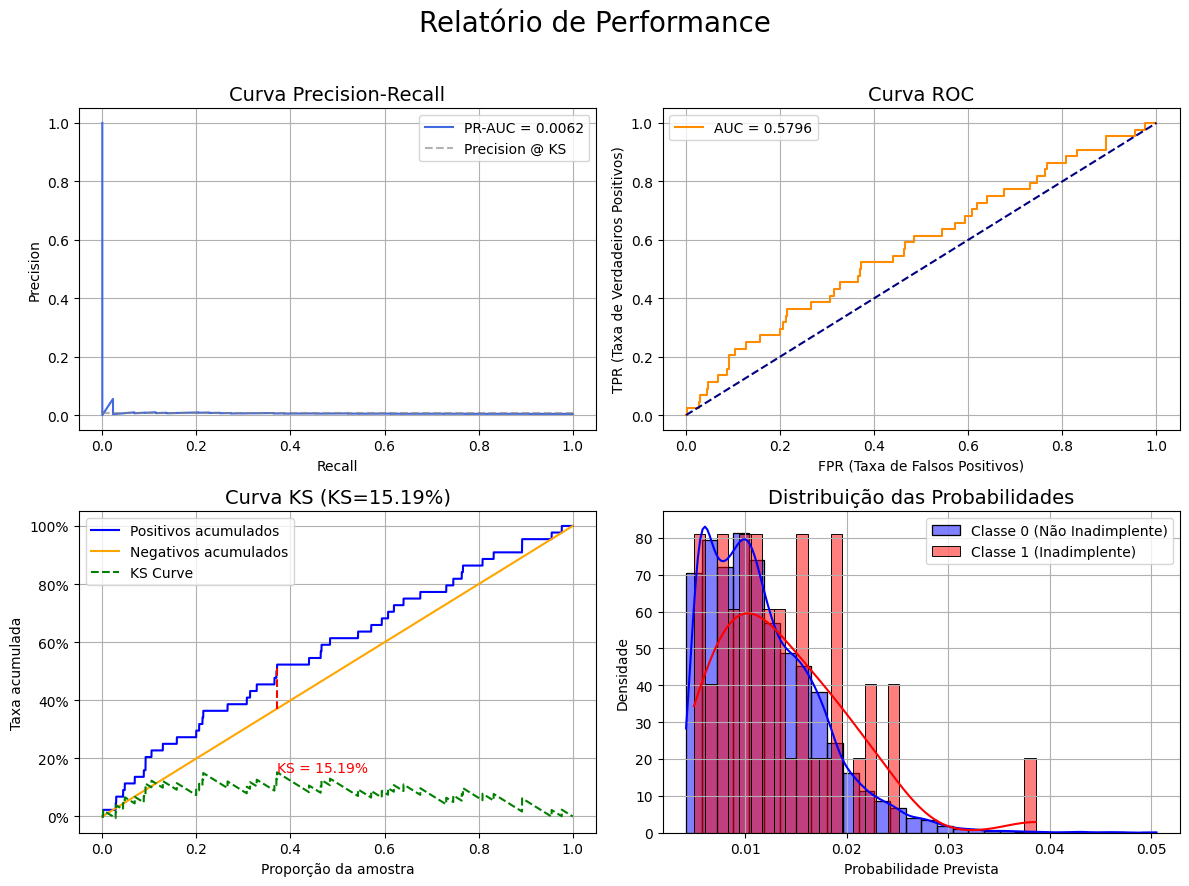

In [315]:
plot_report(y_test, y_pred_proba)

### Referências

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://medium.com/@balemar/t%C3%A9cnicas-para-dados-desbalanceados-smote-e-adasyn-f891f9c46c6e